<h2>Importing Libraries & Dataset</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(
    r"C:/Users/aryan/OneDrive/Documents/Projects/Spam_Detection/spam.csv",
    encoding="ISO-8859-1",
)


df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df["text"] = df.v2


df["label"] = df.v1


df.drop(columns=["v1", "v2"], inplace=True)


df.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


<h2>EDA</h2>

<h3>Checking null values</h3>

In [4]:
df.isnull().sum()

text     0
label    0
dtype: int64

<h3>Dropping null values and rechecking</h3>

In [5]:
df.dropna(inplace=True)
df.isnull().sum()

text     0
label    0
dtype: int64

<h3>Checking memory usage of the dataset, types, and total entries</h3>

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   label   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


<h3>Checking for duplicate values</h3>

In [7]:
df["text"].duplicated().sum()

403

In [8]:
df.duplicated().sum()

403

In [9]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5169 non-null   object
 1   label   5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


<h3>Checking target value distribution</h3>

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])

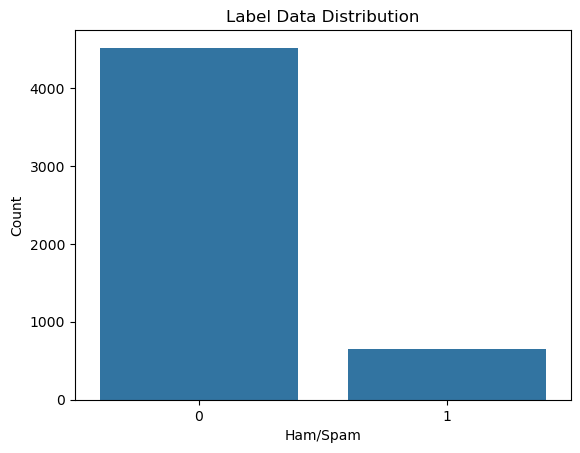

In [12]:
plt.title("Label Data Distribution")
sns.countplot(x=df["label"])
plt.xlabel("Ham/Spam")
plt.ylabel("Count")
plt.show()

<h3>Performing nltk</h3>

In [13]:
import nltk

In [14]:
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
df["num_character"] = df["text"].apply(len)
df.head(2)

,text,label,num_character
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29


In [16]:
df["num_word"] = df["text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [17]:
df.head(2)

,text,label,num_character,num_word
0,"Go until jurong point, crazy.. Available only ...",0,111,24
1,Ok lar... Joking wif u oni...,0,29,8


In [18]:
df["num_sentence"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head(2)

,text,label,num_character,num_word,num_sentence
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2
1,Ok lar... Joking wif u oni...,0,29,8,2


<h3>How many character are used in spam and ham</h3>

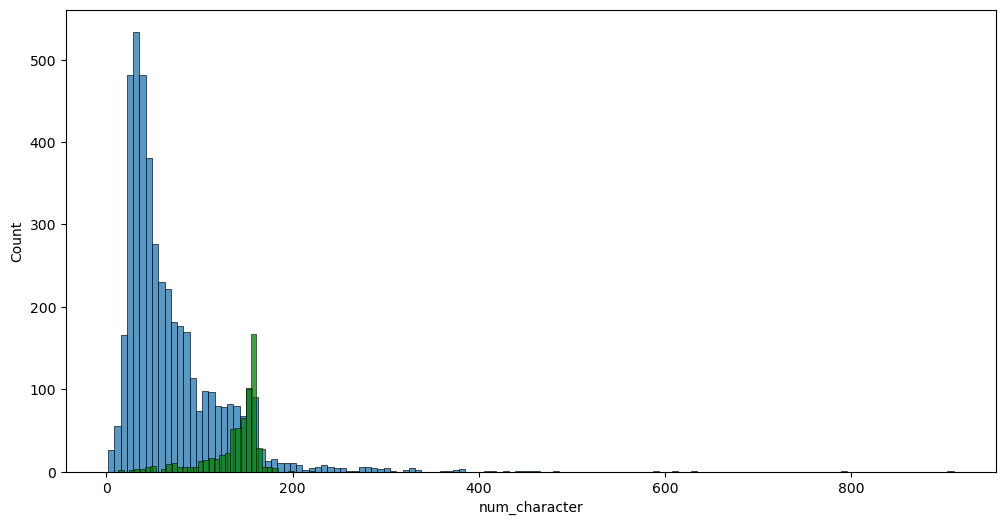

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x=df[df["label"] == 0]["num_character"])
sns.histplot(data=df, x=df[df["label"] == 1]["num_character"], color="green")
plt.show()

<h3>Pairplot</h3>

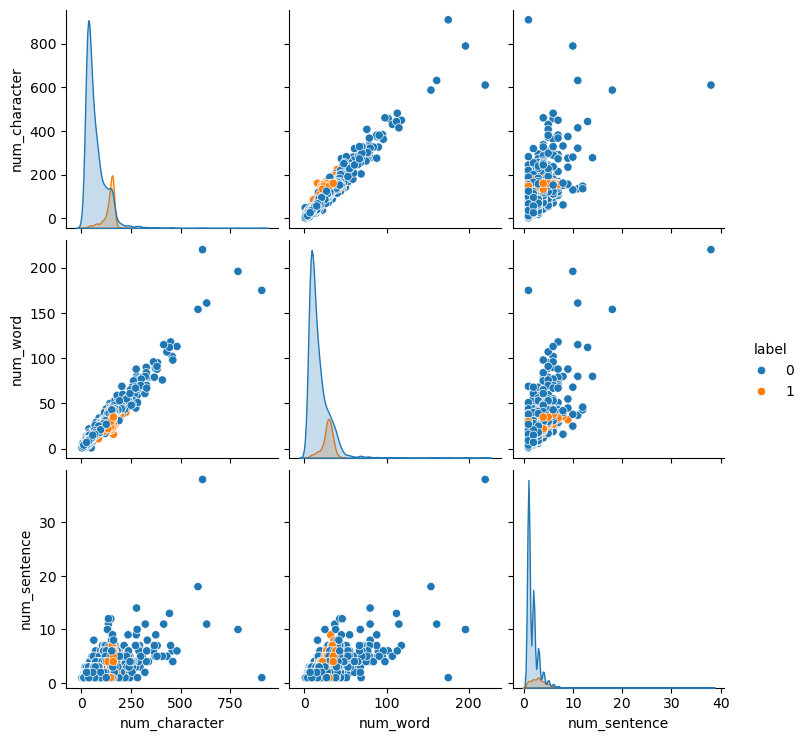

In [20]:
sns.pairplot(df, hue="label")
plt.show()

<h3>Correlation</h3>

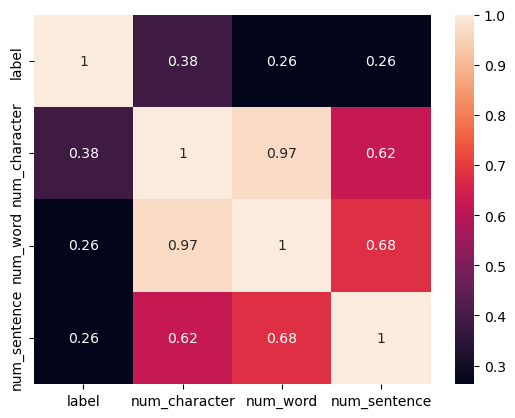

In [21]:
new_df = df.select_dtypes(exclude="object")
sns.heatmap(new_df.corr(), annot=True)
plt.show()

<h2>Data Preprocessing</h2>

In [22]:
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords

ps = PorterStemmer()


def transform_data(text, **args):
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words("english") or i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

In [23]:
df["text"][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [24]:
text = " date wed NUMBER aug NUMBER NUMBER NUMBER NUMBER NUMBER from chris garrigues cwg dated NUMBER NUMBERfaNUMBERd deepeddy com message id NUMBER NUMBER tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening NUMBER NUMBER NUMBER pick_it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER ftoc_pickmsgs NUMBER hit NUMBER NUMBER NUMBER marking NUMBER hits NUMBER NUMBER NUMBER tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER hit that s where the NUMBER hit comes from obviously the version of nmh i m using is delta pick version pick nmh NUMBER NUMBER NUMBER compiled on URL at sun mar NUMBER NUMBER NUMBER NUMBER ict NUMBER and the relevant part of my mh_profile delta mhparam pick seq sel list since the pick command works the sequence actually both of them the one that s explicit on the command line from the search popup and the one that comes from mh_profile do get created kre ps this is still using the version of the code form a day ago i haven t been able to reach the cvs repository today local routing issue i think _______________________________________________ exmh workers mailing list exmh workers URL URL "
transform_data(text)

'date wed number aug number number number number number from chri garrigu cwg date number numberfanumberd deepeddi com messag id number number tmda deepeddi vircio com i can t reproduc thi error for me it is veri repeat like everi time without fail thi is the debug log of the pick happen number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequenc mercuri number number number exec pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequenc mercuri number number number number hit number number number mark number hit number number number tkerror syntax error in express int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace number number sequenc mercuri number hit that s where the number hit come from obvious the version of nmh i m use is delta pick version pick nmh number number number compil on url at sun mar number number number number ict number and the relev part of my delta

<h3>Transforming whole text data</h3>

In [25]:
df["transformed_text"] = df["text"].apply(transform_data)
df.head(2)

,text,label,num_character,num_word,num_sentence,transformed_text
0,"Go until jurong point, crazy.. Available only ...",0,111,24,2,go until jurong point crazi avail onli in bugi...
1,Ok lar... Joking wif u oni...,0,29,8,2,ok lar joke wif u oni


<h2>Train test split</h2>

In [26]:
Y = df.label
X = df.transformed_text


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [27]:
len(X_train), len(X_test), len(y_train), len(y_test)

(4135, 1034, 4135, 1034)

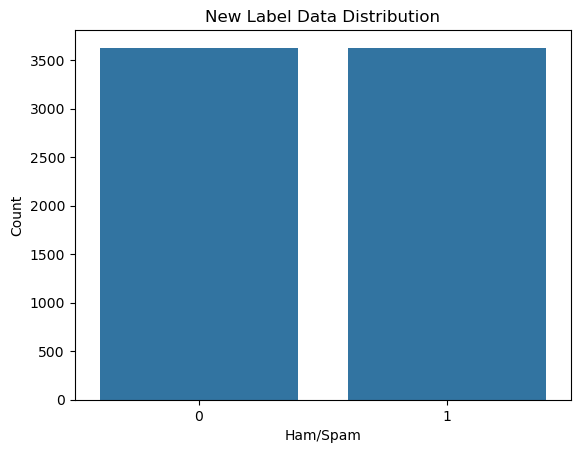

In [28]:
smote = SMOTE(random_state=42)
tf = TfidfVectorizer()
new_X_train = tf.fit_transform(X_train)
_, y_sample = smote.fit_resample(new_X_train, y_train)

plt.title("New Label Data Distribution")
sns.countplot(x=y_sample)
plt.xlabel("Ham/Spam")
plt.ylabel("Count")
plt.show()

<h2>Model Comparision</h2>

In [29]:
from sklearn.preprocessing import FunctionTransformer

from text_utils import text_cleaner_func


text_cleaner_transformer = FunctionTransformer(
    func=lambda x: x.apply(text_cleaner_func), validate=False
)
# validate false to avoid shape check

models = {
    "LR": LogisticRegression(),
    "SVC": SVC(),
    "DTC": DecisionTreeClassifier(),
    "GNB": GaussianNB(),
    "MNB": MultinomialNB(),
    "KNC": KNeighborsClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
}

ACC = 0
NAME = ""
precision_list = []
accuracy_list = []

for name, model in models.items():
    print(name)

    steps = [
        ("cleaner", text_cleaner_transformer),
        ("vec", CountVectorizer(stop_words="english", ngram_range=(1, 2))),
    ]

    if name in ["MNB", "GNB", "KNC"]:
        steps.append(
            ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
        )

    steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("model", model))

    pipeline = Pipeline(steps)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    train_score = pipeline.score(X_train, y_train) * 100
    test_score = pipeline.score(X_test, y_test) * 100

    print(f"Train Accuracy: {train_score}")
    print(f"Test Accuracy: {test_score}")
    print(f"Model Accuracy: {acc}")

    precision_list.append(precision_score(y_test, y_pred))
    accuracy_list.append(acc)

    if acc > ACC:
        ACC = acc
        NAME = name

    print(classification_report(y_test, y_pred))
    print("---" * 20)

LR
Train Accuracy: 96.80773881499395
Test Accuracy: 85.78336557059961
Model Accuracy: 85.78336557059961
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       889
           1       0.50      0.88      0.63       145

    accuracy                           0.86      1034
   macro avg       0.74      0.87      0.77      1034
weighted avg       0.91      0.86      0.87      1034

------------------------------------------------------------
SVC
Train Accuracy: 95.04232164449819
Test Accuracy: 82.30174081237911
Model Accuracy: 82.30174081237911
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       889
           1       0.42      0.69      0.52       145

    accuracy                           0.82      1034
   macro avg       0.68      0.77      0.71      1034
weighted avg       0.87      0.82      0.84      1034

------------------------------------------------------------
DTC
Train Accur

In [30]:
precision_df = pd.DataFrame(data=precision_list, columns=["Precision"])
accuracy_df = pd.DataFrame(data=accuracy_list, columns=["Accuracy"])
accuracy_precision_df = pd.concat([precision_df, accuracy_df], axis=1)
model_name = [x for x in models.keys()]
accuracy_precision_df["Models"] = model_name
a = accuracy_precision_df.set_index(accuracy_precision_df["Models"])
a.drop(columns=["Models"], inplace=True)
a.sort_values(by="Precision", ascending=False)

,Precision,Accuracy
Models,,
MNB,0.848101,96.615087
GNB,0.597222,90.038685
RFC,0.523605,87.040619
LR,0.496094,85.783366
DTC,0.461538,84.139265
SVC,0.420168,82.301741
GBC,0.329923,73.114120
KNC,0.188406,40.232108


In [31]:
from sklearn.preprocessing import FunctionTransformer

models = {
    "LR": LogisticRegression(),
    "SVC": SVC(),
    "DTC": DecisionTreeClassifier(),
    "GNB": GaussianNB(),
    "MNB": MultinomialNB(),
    "KNC": KNeighborsClassifier(),
    "RFC": RandomForestClassifier(),
    "GBC": GradientBoostingClassifier(),
}

ACC = 0
NAME = ""
precision_list = []
accuracy_list = []

for name, model in models.items():
    print(name)

    steps = [
        ("cleaner", text_cleaner_transformer),
        ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
    ]

    if name in ["MNB", "GNB", "KNC"]:
        steps.append(
            ("to_dense", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True))
        )

    steps.append(("smote", SMOTE(random_state=42)))
    steps.append(("model", model))

    pipeline = Pipeline(steps)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    train_score = pipeline.score(X_train, y_train) * 100
    test_score = pipeline.score(X_test, y_test) * 100

    print(f"Train Accuracy: {train_score}")
    print(f"Test Accuracy: {test_score}")
    print(f"Model Accuracy: {acc}")

    precision_list.append(precision_score(y_test, y_pred))
    accuracy_list.append(acc)

    if acc > ACC:
        ACC = acc
        NAME = name

    print(classification_report(y_test, y_pred))
    print("---" * 20)

LR
Train Accuracy: 99.56469165659009
Test Accuracy: 96.80851063829788
Model Accuracy: 96.80851063829788
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       889
           1       0.87      0.91      0.89       145

    accuracy                           0.97      1034
   macro avg       0.93      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034

------------------------------------------------------------
SVC
Train Accuracy: 100.0
Test Accuracy: 97.87234042553192
Model Accuracy: 97.87234042553192
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.98      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

------------------------------------------------------------
DTC
Train Accuracy: 100.0
T

In [32]:
precision_df = pd.DataFrame(data=precision_list, columns=["With_TF_Precision"])
accuracy_df = pd.DataFrame(data=accuracy_list, columns=["With_TF_Accuracy"])
accuracy_precision_df = pd.concat([precision_df, accuracy_df], axis=1)
model_name = [x for x in models.keys()]
accuracy_precision_df["Models"] = model_name
tf_df = accuracy_precision_df.set_index(accuracy_precision_df["Models"])
tf_df.drop(columns=["Models"], inplace=True)
final_df = pd.concat([a, tf_df], axis=1)

final_df.sort_values(by="With_TF_Precision", ascending=False)

,Precision,Accuracy,With_TF_Precision,With_TF_Accuracy
Models,,,,
RFC,0.523605,87.040619,1.000000,96.518375
SVC,0.420168,82.301741,0.984252,97.872340
KNC,0.188406,40.232108,0.976744,93.907157
GBC,0.329923,73.114120,0.923729,95.647969
LR,0.496094,85.783366,0.868421,96.808511
DTC,0.461538,84.139265,0.834586,94.584139
MNB,0.848101,96.615087,0.777143,95.357834
GNB,0.597222,90.038685,0.595349,89.941973


<h2>Model Reliability</h2>

In [33]:
steps = [
    ("cleaner", text_cleaner_transformer),
    ("vec", TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
    ("smote", SMOTE(random_state=42)),
    ("model", SVC()),
]

model = Pipeline(steps)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred) * 100
train_score = model.score(X_train, y_train) * 100
test_score = model.score(X_test, y_test) * 100

print(f"Train Accuracy: {train_score}")
print(f"Test Accuracy: {test_score}")
print(f"Model Accuracy: {acc}")


cv = cross_val_score(model, X_train, y_train, cv=5)


print("CV:", cv)


print("CV Avg:", cv.mean() * 100)

KeyboardInterrupt: 

<h2>Model Hyperparameters</h2>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param = {
    "model__C": [0.1, 1, 10, 100],
    "model__kernel": ["linear", "rbf", "poly", "sigmoid"],
    "model__gamma": ["scale", "auto"],
    "model__degree": [2, 3, 4],
}


randcv = RandomizedSearchCV(model, param, cv=5, n_jobs=1)


randcv.fit(X_train, y_train)

In [ ]:
randcv.best_score_ * 100

In [ ]:
y_pred = randcv.predict(X_test)
precision_score(y_test, y_pred) * 100, accuracy_score(y_test, y_pred) * 100

In [ ]:
steps = [
    ("cleaner", text_cleaner_transformer),
    ("vec", TfidfVectorizer()),
    ("smote", SMOTE(random_state=42)),
    (
        "model",
        SVC(C=10, degree=4, gamma="auto", kernel="linear"),
    ),
]

model = Pipeline(steps)


model.fit(X_train, y_train)

In [ ]:
print("Train Accuracy:", model.score(X_train, y_train) * 100)

print("Test Accuracy:", model.score(X_test, y_test) * 100)

print("Model Accuracy:", accuracy_score(y_test, y_pred) * 100)

print("Precision:", precision_score(y_test, y_pred) * 100)

<h2>Test Model Manually</h2>

In [ ]:
model.fit(X_train, y_train)

<h3>Metrics</h3>

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
text = ["Claim your free Bitcoin now before the offer ends!"]

test = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim: bit.ly/spam123",
    "URGENT: Your account has been suspended. Login now to verify: fakebank.xyz/login",
    "You have been selected for a free cruise to the Bahamas! Call now!",
    "Earn $5000 a week from home! No experience needed. Sign up today!",
    "You’ve been chosen to receive a free iPhone. Just pay $1 shipping!",
    "Act Now! Limited time offer for 0% interest loans!",
    "Click this link to get 100% off on your next order!",
    "Work from home and become rich overnight. Click here!",
    "Your Netflix subscription is expiring. Renew now at netfix-pay.com",
    "Claim your free Bitcoin now before the offer ends!",
]

ans = []
for i in test:

    ans.append(model.predict(pd.Series([i]))[0])
ans

In [ ]:
test = [
    "Hey, are we still meeting for lunch today?",
    "Don't forget to bring your ID for the exam tomorrow.",
    "Mom said dinner is at 8. Don’t be late!",
    "The project deadline has been moved to next Friday.",
    "Here’s the file you asked for, let me know if any changes are needed.",
    "Can you call me when you're free?",
    "I'll be out of town this weekend, want to catch up before that?",
    "Meeting rescheduled to 3 PM. Please confirm your availability.",
    "Happy Birthday! Hope you have a great day 🎉",
    "Attached is the invoice for this month’s services.",
]

ans = []
for i in test:

    ans.append(model.predict(pd.Series([i]))[0])
ans

<h2>Model Export</h2>

In [ ]:
import pickle

model_name = "RFCModel.pkl"

with open(model_name, "wb") as f:
    pickle.dump(model, f)